In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import preprocessing
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from keras.optimizers import Adam, SGD


from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from keras.optimizers import RMSprop
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler

import random
import time
import cv2
from tqdm import tqdm

Num GPUs Available:  0


In [2]:
image_folder = "./Flipkart/Images/"
# Load CSV into Pandas DataFrame
text_data_path = r'./Flipkart/flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(text_data_path)
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
845,9e90fb6c7870637b6f794e4b4c26bd7e,2015-12-29 05:07:38 +0000,http://www.flipkart.com/feetje-trousers/p/itmd...,Feetje Trousers,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",TRODN38Q8HHZHRFE,569.0,569.0,9e90fb6c7870637b6f794e4b4c26bd7e.jpg,False,Feetje Trousers - Buy Blue Feetje Trousers For...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Age Group""..."
482,a76bf8400b3dbcdbe5a5678f4a8ea0f6,2016-01-07 05:50:25 +0000,http://www.flipkart.com/arb-hp-pavilion-dv5t-1...,ARB HP Pavilion dv5t-1000 Replacement 6 Cell L...,"[""Computers >> Laptop Accessories >> Batteries...",ACCDX9Y3ZR9EUGXJ,3499.0,1499.0,a76bf8400b3dbcdbe5a5678f4a8ea0f6.jpg,False,Buy ARB HP Pavilion dv5t-1000 Replacement 6 Ce...,No rating available,No rating available,ARB,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
183,3830dda3491cd5b28ed42ae544bc44f0,2015-12-01 12:40:44 +0000,http://www.flipkart.com/rockmantra-blue-water-...,Rockmantra Blue Water Abstracts Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Rockmantr...",MUGEAGGKDCJHRYBY,499.0,199.0,3830dda3491cd5b28ed42ae544bc44f0.jpg,False,Rockmantra Blue Water Abstracts Ceramic Mug (5...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
89,aebf3a2172b33ef09acb472009967812,2016-01-04 00:20:04 +0000,http://www.flipkart.com/parv-collections-showp...,Parv Collections Showpiece - 12 cm,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIE4THT2KHHGU8H,1500.0,1085.0,aebf3a2172b33ef09acb472009967812.jpg,False,Parv Collections Showpiece - 12 cm (Polyresi...,No rating available,No rating available,Parv Collections,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
340,8963e56482bbd3e9d05e0709d61ee0ca,2015-12-01 06:13:00 +0000,http://www.flipkart.com/engage-blush-drizzle-c...,Engage Blush and Drizzle Combo Set,"[""Beauty and Personal Care >> Fragrances >> De...",CAGE68FFYRMDRF3X,360.0,350.0,8963e56482bbd3e9d05e0709d61ee0ca.jpg,False,Flipkart.com: Buy Engage Blush and Drizzle Com...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ..."


In [3]:
# Split the product_category_tree column into subcategory columns and keep only the 2 first catagory levels
category_lables = df['product_category_tree'].str.split(' >> ', expand=True).iloc[:, :2][0]

# Remove square brackets and double quotes from all strings in the DataFrame
df['category'] = category_lables.apply(lambda x: str(x).replace('[', '').replace('"', '').replace(']', ''))
list_categories = df['category'].unique().tolist()
df['category']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1050, dtype: object

In [4]:
le = preprocessing.LabelEncoder()
le.fit(df["category"])
df['category_encoded'] = le.transform(df["category"])
category_dict = dict(zip(df['category'], df['category_encoded']))
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

# Utility functions

* Metrics

In [5]:
def calculate_ari(labels_true, labels_pred):
    ari = np.round(adjusted_rand_score(labels_true, labels_pred), 2)
    return ari

def calculate_silhouette_score(data, labels):
    silhouette = np.round(silhouette_score(data, labels), 2)
    return silhouette

# Supervised Classification
Four approaches are presented:

* A simple approach involving the initial preparation of all images before supervised classification.
* An approach using a data generator, enabling easy data augmentation. The images are directly retrieved on-the-fly from the image directory.

* Create classification model

In [6]:
batch_size = 64

In [7]:
def create_model_fct(model, n_class, dropout_rate, optimization='rmsprop'):

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(n_class, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimization, metrics=["accuracy"])

    print(model.summary())
    
    return model

* Initial image set up

In [8]:
def image_prep_fct(data):
    prepared_images = []  # List to store prepared images
    for image_num in range(data.shape[0]):
        # Load image, resize to (224, 224), and convert to NumPy array
        img = load_img(glob(os.path.join(image_folder, data['image'].tolist()[image_num]))[0],
                       target_size=(224, 224))
        img = img_to_array(img)

        # Reshape the array to match the expected input shape
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Preprocess the image according to the requirements of the VGG16 model
        img = preprocess_input(img)

        # Append the prepared image to the list
        prepared_images.append(img)

    # Convert the list of prepared images to a NumPy array
    prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np

In [9]:
# Split the DataFrame into dev (training) and final valisation sets
df_sup_dev, df_sup_test = train_test_split(df, test_size=0.15)

# Print the shapes of the resulting sets
print("Training set shape:", df_sup_dev.shape)
print("Test set shape:", df_sup_test.shape)

Training set shape: (892, 17)
Test set shape: (158, 17)


In [10]:
# Prepare images from training dataframe
images_sup_dev = image_prep_fct(df_sup_dev)
print(images_sup_dev.shape)
# Prepare images from the final validation DataFramedf
images_sup_test= image_prep_fct(df_sup_test)
print(images_sup_test.shape)

(892, 224, 224, 3)
(158, 224, 224, 3)


In [11]:
X_sup_dev = images_sup_dev
y_sup_dev = to_categorical(df_sup_dev['category_encoded'])

X_sup_test = images_sup_test
y_sup_test = to_categorical(df_sup_test['category_encoded'])
print(y_sup_dev.shape)
y_sup_dev

(892, 7)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
X_sup_dev_train, X_sup_dev_val, y_sup_dev_train, y_sup_dev_val = train_test_split(X_sup_dev, y_sup_dev, 
                                                                    stratify=y_sup_dev, test_size=0.175)
X_sup_dev_train.shape, X_sup_dev_val.shape, X_sup_test.shape

((735, 224, 224, 3), (157, 224, 224, 3), (158, 224, 224, 3))

#### 2-1 VGG16 Supervised classification

In [36]:
model_vgg_sup = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_vgg_sup = create_model_fct(model_vgg_sup, 7, 0.5)

# Define the path to save best weights
model_vgg_sup_save_path = "./model_vgg_sup_best_weights.h5"

# Define the path to save training history
history_vgg_sup_save_path = "./model_vgg_sup_training_history.json"

# Create callbacks including the custom history saver
checkpoint_vgg_sup = ModelCheckpoint(model_vgg_sup_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list_vgg_sup = [checkpoint_vgg_sup, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
history_vgg_sup = model_vgg_sup.fit(X_sup_dev_train, y_sup_dev_train,
                            epochs=50, batch_size=batch_size, 
                            callbacks=callbacks_list_vgg_sup,
                            validation_data=(X_sup_dev_val ,y_sup_dev_val),
                            verbose=1)

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 5.5353 - accuracy: 0.4517
Epoch 1: val_loss improved from inf to 1.54602, saving model to .\model_vgg_sup_best_weights.h5
12/12 [==============================] - 112s 9s/step - loss: 5.5353 - accuracy: 0.4517 - val_loss: 1.5460 - val_accuracy: 0.7643
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.7503 - accuracy: 0.6980
Epoch 2: val_loss improved from 1.54602 to 1.23220, saving model to .\model_vgg_sup_best_weights.h5
12/12 [==============================] - 106s 9s/step - loss: 1.7503 - accuracy: 0.6980 - val_loss: 1.2322 - val_accuracy: 0.7771
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.3489 - accuracy: 0.7388
Epoch 3: val_loss improved from 1.23220 to 1.05731, saving model to .\model_vgg_sup_best_weights.h5
12/12 [==============================] - 106s 9s/step - loss: 1.3489 - accuracy: 0.7388 - val_loss: 1.0573 - val_accuracy: 0.7962
Epoch 4/50
12/12 [=========================

In [38]:
# Score du dernier epoch

loss_sup_dev_train, accuracy_sup_dev_train = model_vgg_sup.evaluate(X_sup_dev_train, y_sup_dev_train, verbose=True)
print("Training Accuracy for VGG16 Model supervised classification: {:.4f}".format(accuracy_sup_dev_train))
print()
loss_sup_dev_val, accuracy_sup_dev_val = model_vgg_sup.evaluate(X_sup_dev_val, y_sup_dev_val, verbose=True)
print("Validation Accuracy for VGG16 Model supervised classification:  {:.4f}".format(accuracy_sup_dev_val))

23/23 [==============================] - 105s 5s/step - loss: 0.0014 - accuracy: 1.0000
Training Accuracy for VGG16 Model supervised classification: 1.0000

5/5 [==============================] - 22s 4s/step - loss: 0.9939 - accuracy: 0.8599
Validation Accuracy for VGG16 Model supervised classification:  0.8599


In [39]:
# Score de l'epoch optimal
model_vgg_sup.load_weights(model_vgg_sup_save_path)

loss_sup_dev_val, accuracy_sup_dev_val, = model_vgg_sup.evaluate(X_sup_dev_val, y_sup_dev_val, verbose=False)
print("Validation Accuracy for VGG16 Model supervised classification:  {:.4f}".format(accuracy_sup_dev_val,))

loss_sup_test, accuracy_sup_test = model_vgg_sup.evaluate(X_sup_test, y_sup_test, verbose=False)
print("Test Accuracy for VGG16 Model supervised classification:  {:.4f}".format(accuracy_sup_test))


Validation Accuracy for VGG16 Model supervised classification:  0.8599
Test Accuracy for VGG16 Model supervised classification:  0.8038


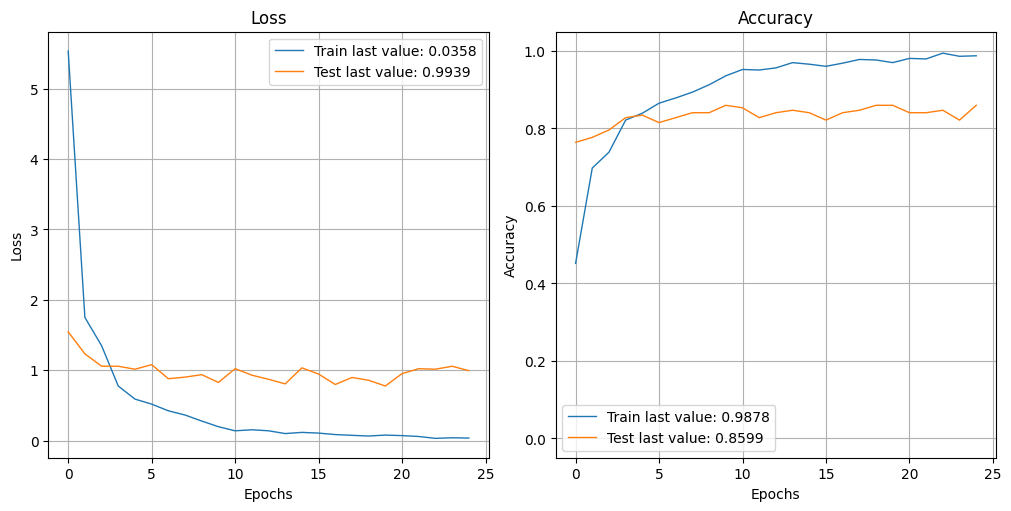

In [40]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history_vgg_sup)
plot_history(history_vgg_sup, path="standard.png")
plt.close()

In [41]:
y_sup_dev_val_num = np.argmax(y_sup_dev_val, axis=1)
y_dev_test_pred = np.argmax(model_vgg_sup.predict(X_sup_dev_val), axis=1)


5/5 [==============================] - 23s 5s/step


In [42]:
conf_mat = confusion_matrix(y_sup_dev_val_num, y_dev_test_pred)
print(conf_mat)

[[15  1  1  0  2  2  0]
 [ 0 20  1  1  0  0  0]
 [ 1  1 20  0  0  0  0]
 [ 3  0  1 18  1  0  0]
 [ 2  0  0  1 20  0  0]
 [ 0  0  2  0  0 21  0]
 [ 0  1  1  0  0  0 21]]


In [28]:
def conf_mat_transform2(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print(type(corresp))
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    if not np.array_equal(corresp, np.array([0, 1, 2, 3, 4, 5, 6])):
        labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
        return labels['y_pred_transform'], corresp
    else:
        return labels['y_pred'], corresp

In [44]:
y_sup_dev_val_transform, corresp = conf_mat_transform2(y_sup_dev_val_num, y_dev_test_pred)
conf_mat_dev_test = confusion_matrix(y_dev_test_pred, y_sup_dev_val_transform)
print(conf_mat_dev_test)
print(classification_report(y_sup_dev_val_num, y_sup_dev_val_transform))


<class 'numpy.ndarray'>
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[21  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0]
 [ 0  0 26  0  0  0  0]
 [ 0  0  0 20  0  0  0]
 [ 0  0  0  0 23  0  0]
 [ 0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0 21]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        21
           1       0.87      0.91      0.89        22
           2       0.77      0.91      0.83        22
           3       0.90      0.78      0.84        23
           4       0.87      0.87      0.87        23
           5       0.91      0.91      0.91        23
           6       1.00      0.91      0.95        23

    accuracy                           0.86       157
   macro avg       0.86      0.86      0.86       157
weighted avg       0.86      0.86      0.86       157



#### 2-2 RESNET50 Supervised classification

In [45]:
model_resnet_sup = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_resnet_sup = create_model_fct(model_resnet_sup, 7, 0.5)

# Define the path to save best weights
model_resnet_sup_save_path = "./model_resnet_sup_best_weights.h5"

# Define the path to save training history
history_resnet_sup_save_path = "./model_resnet_sup_training_history.json"

# Create callbacks including the custom history saver
checkpoint_resnet_sup = ModelCheckpoint(model_resnet_sup_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list_resnet_sup = [checkpoint_resnet_sup, es]

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [46]:
history_resnet_sup = model_resnet_sup.fit(X_sup_dev_train, y_sup_dev_train,
                            epochs=50, batch_size=batch_size, 
                            callbacks=callbacks_list_resnet_sup,
                            validation_data=(X_sup_dev_val ,y_sup_dev_val),
                            verbose=1)

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 2.5310 - accuracy: 0.4952
Epoch 1: val_loss improved from inf to 0.61598, saving model to .\model_resnet_sup_best_weights.h5
12/12 [==============================] - 54s 4s/step - loss: 2.5310 - accuracy: 0.4952 - val_loss: 0.6160 - val_accuracy: 0.7643
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.8068
Epoch 2: val_loss improved from 0.61598 to 0.58022, saving model to .\model_resnet_sup_best_weights.h5
12/12 [==============================] - 47s 4s/step - loss: 0.6449 - accuracy: 0.8068 - val_loss: 0.5802 - val_accuracy: 0.7962
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.8299
Epoch 3: val_loss did not improve from 0.58022
12/12 [==============================] - 47s 4s/step - loss: 0.5380 - accuracy: 0.8299 - val_loss: 0.6557 - val_accuracy: 0.7452
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8762

In [47]:
# Score du dernier epoch

loss_sup_dev_train, accuracy_sup_dev_train = model_resnet_sup.evaluate(X_sup_dev_train, y_sup_dev_train, verbose=True)
print("Training Accuracy for RESNET50 Model supervised classification: {:.4f}".format(accuracy_sup_dev_train))
print()
loss_sup_dev_val, accuracy_sup_dev_val = model_resnet_sup.evaluate(X_sup_dev_val, y_sup_dev_val, verbose=True)
print("Validation Accuracy for RESNET50 Model supervised classification:  {:.4f}".format(accuracy_sup_dev_val))

23/23 [==============================] - 45s 2s/step - loss: 0.0121 - accuracy: 0.9973
Training Accuracy for RESNET50 Model supervised classification: 0.9973

5/5 [==============================] - 10s 2s/step - loss: 0.6117 - accuracy: 0.8471
Validation Accuracy for RESNET50 Model supervised classification:  0.8471


In [48]:
# Score de l'epoch optimal
model_resnet_sup.load_weights(model_resnet_sup_save_path)

loss_sup_dev_val, accuracy_sup_dev_val, = model_resnet_sup.evaluate(X_sup_dev_val, y_sup_dev_val, verbose=False)
print("Validation Accuracy for RESNET50 Model supervised classification:  {:.4f}".format(accuracy_sup_dev_val,))

loss_sup_test, accuracy_sup_test = model_resnet_sup.evaluate(X_sup_test, y_sup_test, verbose=False)
print("Test Accuracy for RESNET50 Model supervised classification:  {:.4f}".format(accuracy_sup_test))


Validation Accuracy for RESNET50 Model supervised classification:  0.8854
Test Accuracy for RESNET50 Model supervised classification:  0.8101


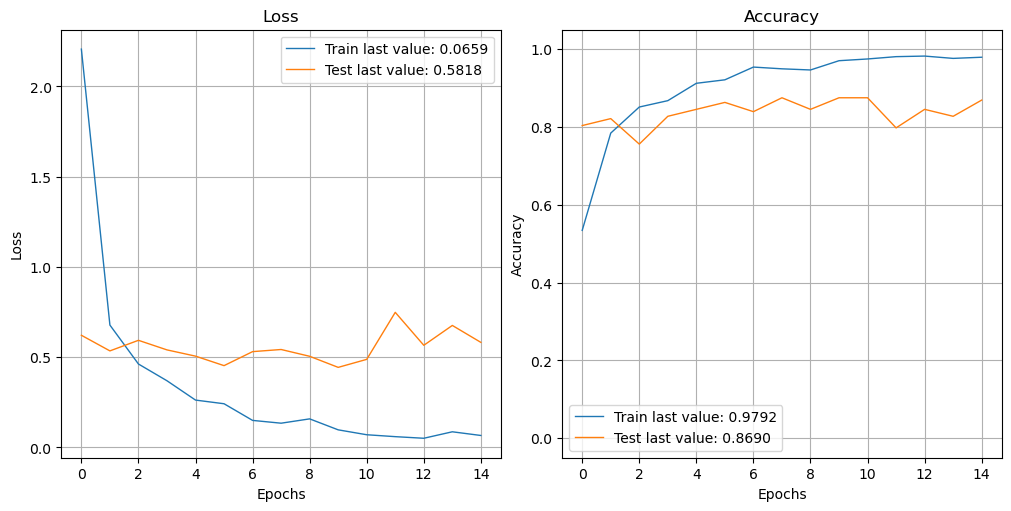

In [64]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history_resnet_sup)
plot_history(history_resnet_sup, path="standard.png")
plt.close()

In [54]:
y_sup_dev_val_num = np.argmax(y_sup_dev_val, axis=1)
y_dev_test_pred = np.argmax(model_resnet_sup.predict(X_sup_dev_val), axis=1)


# Calculate ARI score on validation set
ari_score = adjusted_rand_score(y_sup_dev_val_num, y_dev_test_pred)
print("ARI: " + str(ari_score))

5/5 [==============================] - 11s 2s/step
ARI: 0.7538201925156914


In [35]:
y_sup_dev_val.shape, X_sup_dev_val.shape

((157, 7), (157, 224, 224, 3))

In [36]:
y_sup_dev_val,X_sup_dev_val

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32),
 array([[[[149.061     , 138.22101   , 131.32      ],
          [150.061     , 137.22101   , 130.32      ],
          [151.061     , 138.22101   , 130.32      ],
          ...,
          [151.061     , 138.22101   , 131.32      ],
          [151.061     , 138.22101   , 131.32      ],
          [151.061     , 138.22101   , 131.32      ]],
 
         [[149.061     , 138.22101   , 131.32      ],
          [150.061     , 137.22101   , 130.32      ],
          [151.061     , 138.22101   , 130.32      ],
          ...,
          [151.061     , 138.22101   , 131.32      ],
          [151.061     , 138.22101   , 131.32      ],
          [151.061     , 138.22101   , 131.32      ]],
 
         [[151.061     , 138.22101   , 131.32      ]

In [50]:
conf_mat = confusion_matrix(y_sup_dev_val_num, y_dev_test_pred)
print(conf_mat)

[[12  0  1  2  5  1  0]
 [ 0 20  2  0  0  0  0]
 [ 0  1 21  0  0  0  0]
 [ 0  0  0 20  2  1  0]
 [ 0  0  0  0 23  0  0]
 [ 0  0  1  1  0 21  0]
 [ 0  0  1  0  0  0 22]]


In [51]:
y_sup_dev_val_transform, corresp = conf_mat_transform2(y_sup_dev_val_num, y_dev_test_pred)
conf_mat_dev_test = confusion_matrix(y_dev_test_pred, y_sup_dev_val_transform)
print(conf_mat_dev_test)
print(classification_report(y_sup_dev_val_num, y_sup_dev_val_transform))


<class 'numpy.ndarray'>
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[12  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0]
 [ 0  0 26  0  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  0  0 30  0  0]
 [ 0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0 22]]
              precision    recall  f1-score   support

           0       1.00      0.57      0.73        21
           1       0.95      0.91      0.93        22
           2       0.81      0.95      0.88        22
           3       0.87      0.87      0.87        23
           4       0.77      1.00      0.87        23
           5       0.91      0.91      0.91        23
           6       1.00      0.96      0.98        23

    accuracy                           0.89       157
   macro avg       0.90      0.88      0.88       157
weighted avg       0.90      0.89      0.88       157



### 2-3 Hyper-parameters optimisation

Training with hyperparameters: ResNet50_adam_0.5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                           

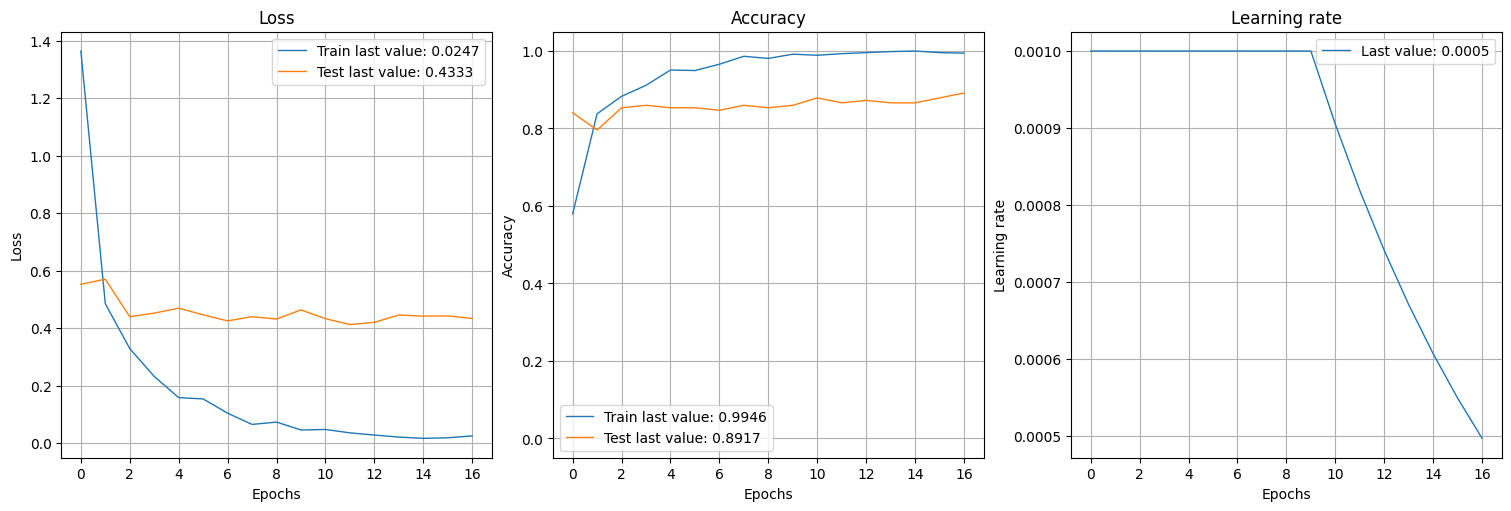

5/5 [==============================] - 12s 2s/step
ARI: 0.760668279103023
      Model epochs  dropout_rate optimization       ARI  accuracy validation  \
0  ResNet50     17           0.5         adam  0.760668              0.89172   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.810127         0.433263   0.909543         925.728151  
Training with hyperparameters: ResNet50_sgd_0.5
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_

C:\Users\Imtech\AppData\Local\Temp\ipykernel_16832\699281936.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_classSup_df = results_classSup_df.append({


 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization) 

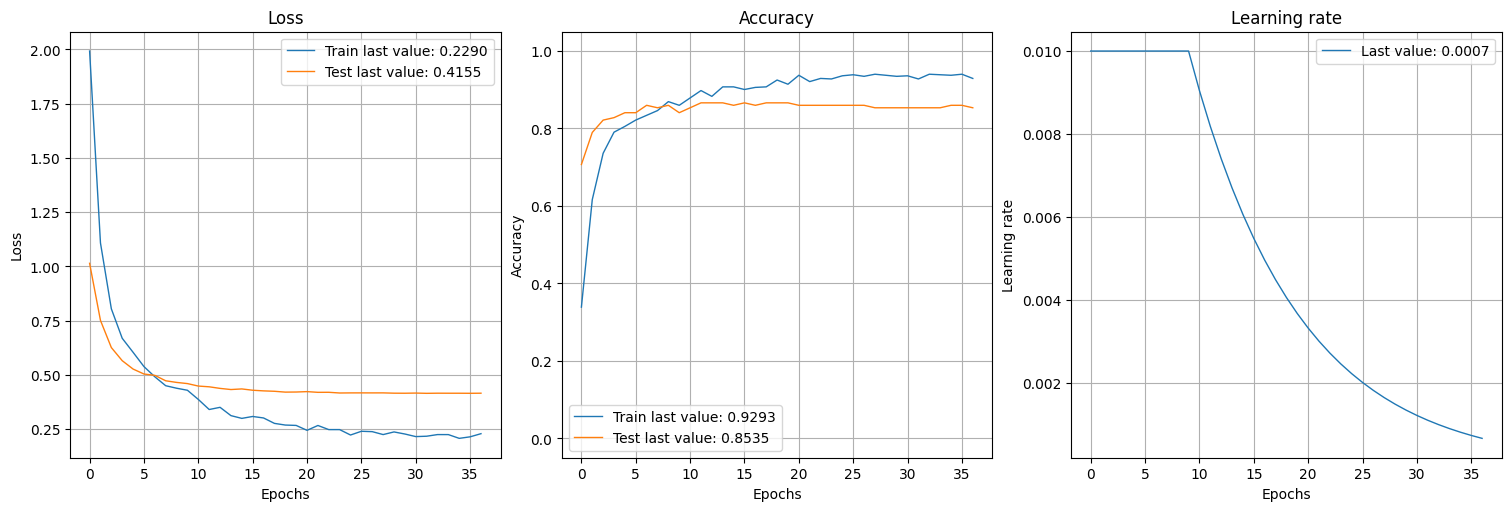

5/5 [==============================] - 14s 2s/step
ARI: 0.6841846233215017
      Model epochs  dropout_rate optimization       ARI  accuracy validation  \
0  ResNet50     17           0.5         adam  0.760668             0.891720   
1  ResNet50     37           0.5          sgd  0.684185             0.853503   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.810127         0.433263   0.909543         925.728151  
1       0.765823         0.415533   0.696533        2124.999091  
Training with hyperparameters: ResNet50_rmsprop_0.5
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                     

C:\Users\Imtech\AppData\Local\Temp\ipykernel_16832\699281936.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_classSup_df = results_classSup_df.append({


 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

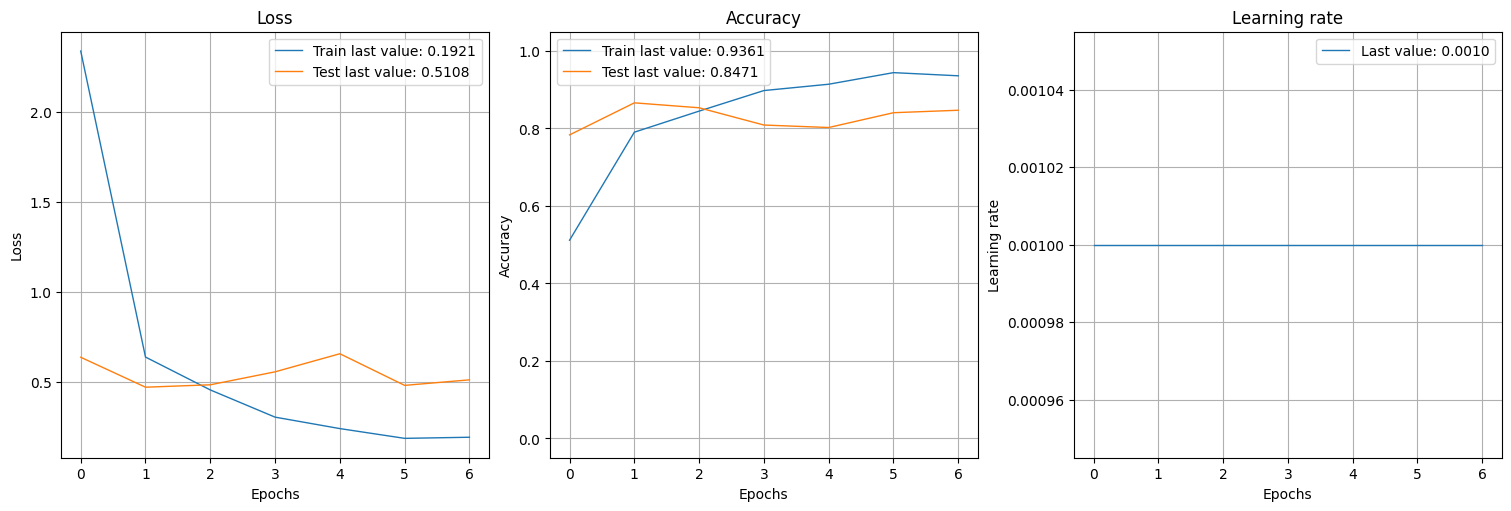

5/5 [==============================] - 14s 3s/step
ARI: 0.6771810795826706
      Model epochs  dropout_rate optimization       ARI  accuracy validation  \
0  ResNet50     17           0.5         adam  0.760668             0.891720   
1  ResNet50     37           0.5          sgd  0.684185             0.853503   
2  ResNet50      7           0.5      rmsprop  0.677181             0.847134   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.810127         0.433263   0.909543         925.728151  
1       0.765823         0.415533   0.696533        2124.999091  
2       0.784810         0.510813   0.972122         499.978605  
Training with hyperparameters: VGG16_adam_0.5
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1

C:\Users\Imtech\AppData\Local\Temp\ipykernel_16832\699281936.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_classSup_df = results_classSup_df.append({


Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 7.2567 - accuracy: 0.3741 
Epoch 1: val_loss improved from inf to 1.67477, saving model to .\best_model_weights_class_sup_VGG16_adam_0.5.h5
12/12 [==============================] - 160s 13s/step - loss: 7.2567 - accuracy: 0.3741 - val_loss: 1.6748 - val_accuracy: 0.6943 - lr: 4.9659e-04
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.9321 - accuracy: 0.7306 
Epoch 2: val_loss improved from 1.67477 to 1.10626, saving model to .\best_model_weights_class_sup_VGG16_adam_0.5.h5
12/12 [==============================] - 157s 13s/step - loss: 1.9321 - accuracy: 0.7306 - val_loss: 1.1063 - val_accuracy: 0.7580 - lr: 4.9659e-04
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.1365 - accuracy: 0.8109 
Epoch 3: val_loss improved from 1.10626 to 0.78328, saving model to .\best_model_weights_class_sup_VGG16_adam_0.5.h5
12/12 [==============================] - 173s 15s/step - loss: 1.1365 - 

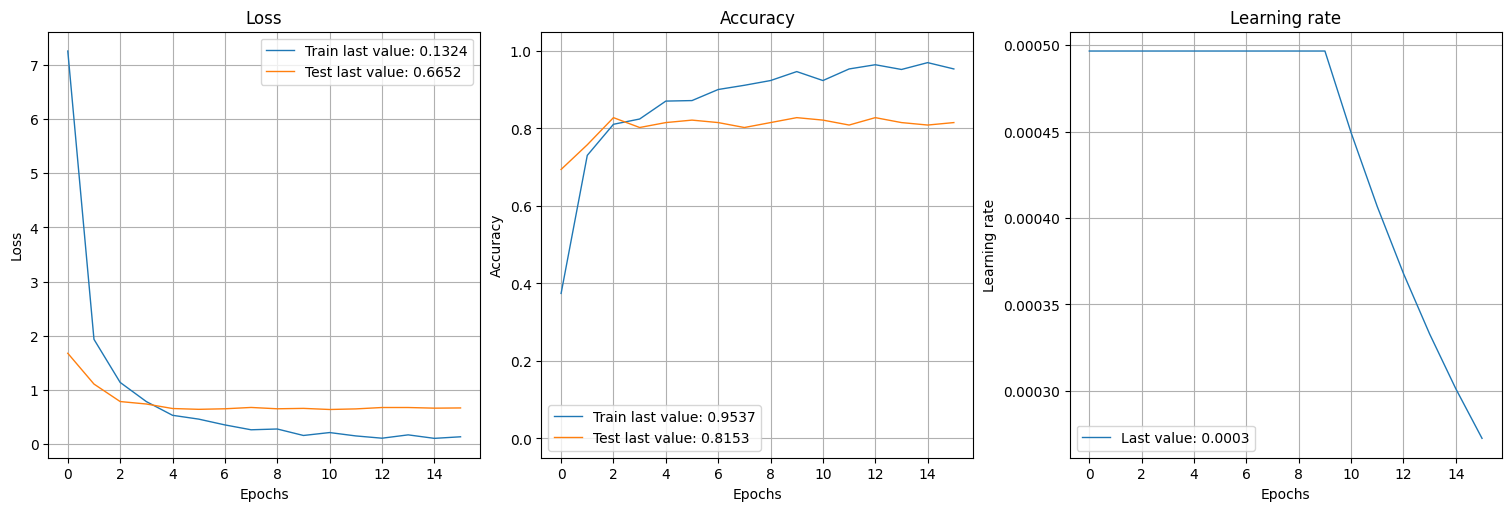

5/5 [==============================] - 24s 5s/step
ARI: 0.6134781495600453
      Model epochs  dropout_rate optimization       ARI  accuracy validation  \
0  ResNet50     17           0.5         adam  0.760668             0.891720   
1  ResNet50     37           0.5          sgd  0.684185             0.853503   
2  ResNet50      7           0.5      rmsprop  0.677181             0.847134   
3     VGG16     16           0.5         adam  0.613478             0.815287   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.810127         0.433263   0.909543         925.728151  
1       0.765823         0.415533   0.696533        2124.999091  
2       0.784810         0.510813   0.972122         499.978605  
3       0.797468         0.665189   1.147289        2362.392300  
Training with hyperparameters: VGG16_sgd_0.5
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


C:\Users\Imtech\AppData\Local\Temp\ipykernel_16832\699281936.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_classSup_df = results_classSup_df.append({


Total params: 14,847,815
Trainable params: 133,127
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 12.3998 - accuracy: 0.1279
Epoch 1: val_loss improved from inf to 5.02004, saving model to .\best_model_weights_class_sup_VGG16_sgd_0.5.h5
12/12 [==============================] - 136s 11s/step - loss: 12.3998 - accuracy: 0.1279 - val_loss: 5.0200 - val_accuracy: 0.2229 - lr: 6.7206e-04
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 8.8831 - accuracy: 0.1946
Epoch 2: val_loss improved from 5.02004 to 3.32564, saving model to .\best_model_weights_class_sup_VGG16_sgd_0.5.h5
12/12 [==============================] - 118s 10s/step - loss: 8.8831 - accuracy: 0.1946 - val_loss: 3.3256 - val_accuracy: 0.3885 - lr: 6.7206e-04
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 6.5407 - accuracy: 0.2966
Epoch 3: val_loss improved from 3.325

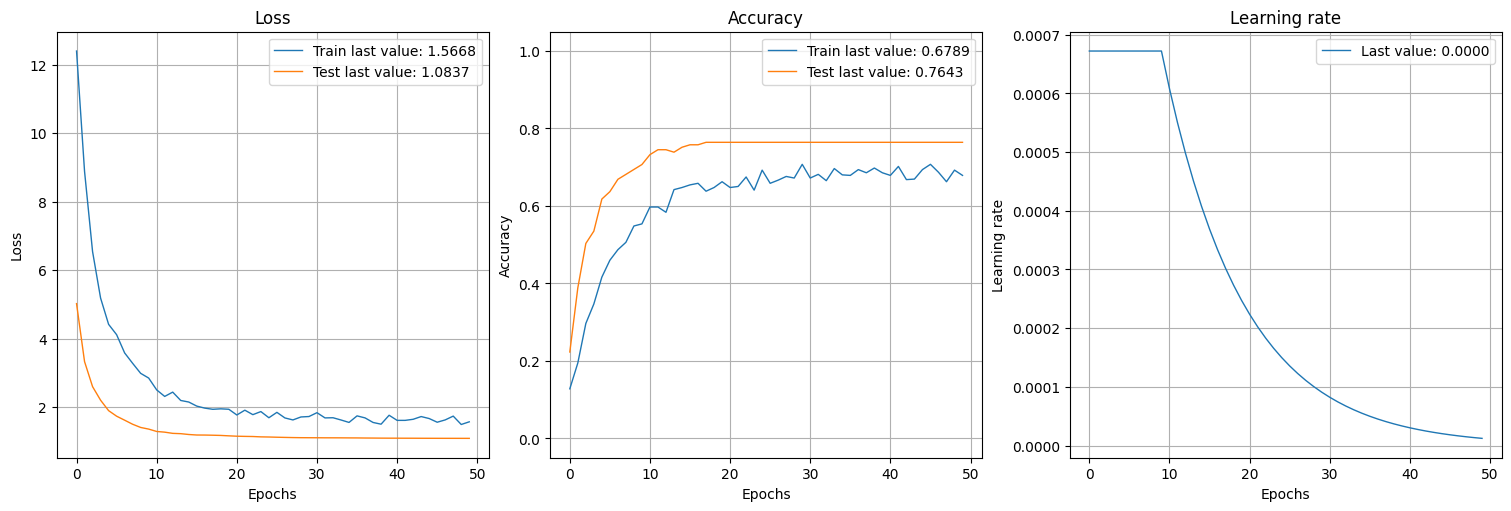

5/5 [==============================] - 19s 4s/step
ARI: 0.5297081444989666
      Model epochs  dropout_rate optimization       ARI  accuracy validation  \
0  ResNet50     17           0.5         adam  0.760668             0.891720   
1  ResNet50     37           0.5          sgd  0.684185             0.853503   
2  ResNet50      7           0.5      rmsprop  0.677181             0.847134   
3     VGG16     16           0.5         adam  0.613478             0.815287   
4     VGG16     50           0.5          sgd  0.529708             0.764331   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.810127         0.433263   0.909543         925.728151  
1       0.765823         0.415533   0.696533        2124.999091  
2       0.784810         0.510813   0.972122         499.978605  
3       0.797468         0.665189   1.147289        2362.392300  
4       0.708861         1.083699   1.723339        6042.507635  
Training with hyperparameters: VGG16_rmsprop_0.5

C:\Users\Imtech\AppData\Local\Temp\ipykernel_16832\699281936.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_classSup_df = results_classSup_df.append({


Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 5.1755 - accuracy: 0.4626
Epoch 1: val_loss improved from inf to 1.70906, saving model to .\best_model_weights_class_sup_VGG16_rmsprop_0.5.h5
12/12 [==============================] - 105s 9s/step - loss: 5.1755 - accuracy: 0.4626 - val_loss: 1.7091 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.9396 - accuracy: 0.6952
Epoch 2: val_loss improved from 1.70906 to 1.16711, saving model to .\best_model_weights_class_sup_VGG16_rmsprop_0.5.h5
12/12 [==============================] - 104s 9s/step - loss: 1.9396 - accuracy: 0.6952 - val_loss: 1.1671 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.2368 - accuracy: 0.7701
Epoch 3: val_loss improved from 1.16711 to 1.04253, saving model to .\best_model_weights_class_sup_VGG16_rmsprop_0.5.h5
12/12 [==============================] - 104s 9s/step - loss: 1.2368 - accur

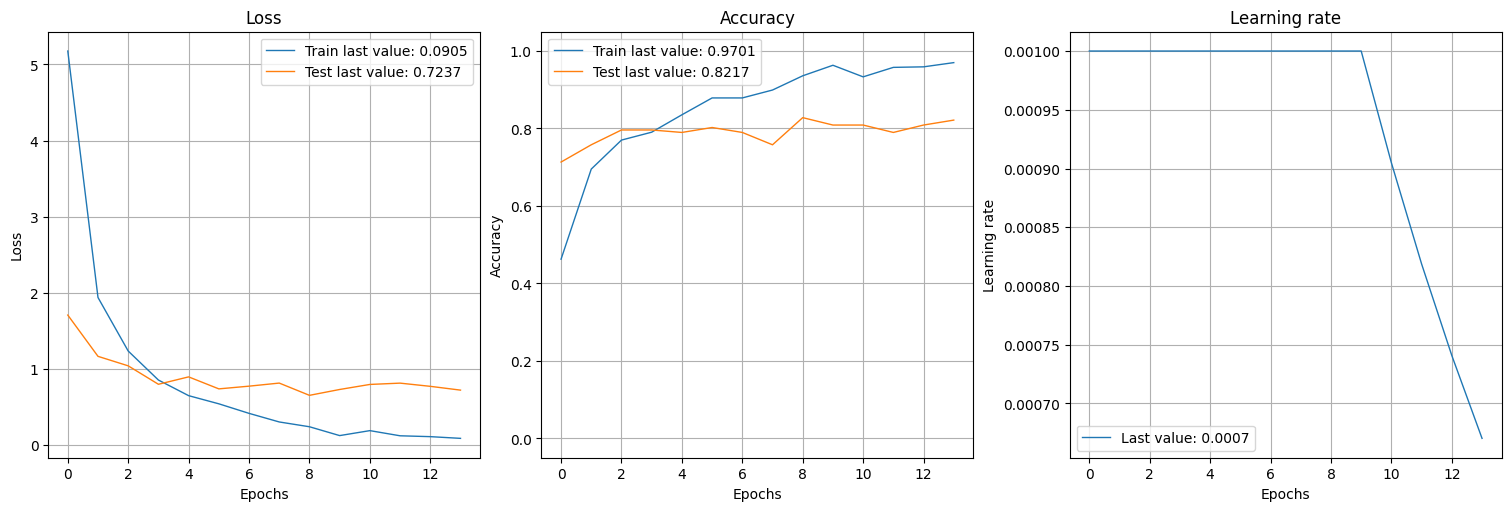

5/5 [==============================] - 19s 4s/step
ARI: 0.6267430592320434
      Model epochs  dropout_rate optimization       ARI  accuracy validation  \
0  ResNet50     17           0.5         adam  0.760668             0.891720   
1  ResNet50     37           0.5          sgd  0.684185             0.853503   
2  ResNet50      7           0.5      rmsprop  0.677181             0.847134   
3     VGG16     16           0.5         adam  0.613478             0.815287   
4     VGG16     50           0.5          sgd  0.529708             0.764331   
5     VGG16     14           0.5      rmsprop  0.626743             0.821656   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.810127         0.433263   0.909543         925.728151  
1       0.765823         0.415533   0.696533        2124.999091  
2       0.784810         0.510813   0.972122         499.978605  
3       0.797468         0.665189   1.147289        2362.392300  
4       0.708861         1.083699 

C:\Users\Imtech\AppData\Local\Temp\ipykernel_16832\699281936.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_classSup_df = results_classSup_df.append({


In [15]:
from plot_keras_history import show_history, plot_history

def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create an empty DataFrame for post-treatment
results_classSup_df = pd.DataFrame(columns=['Model', 'epochs', 'dropout_rate', 'optimization', 'ARI',
                                   'accuracy validation', 'accuracy test',
                                   'loss validation', 'loss test',
                                   'training_time (s)'])

model_vgg_sup_opt = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_resnet_sup_opt = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
dict_model = {'VGG16': model_vgg_sup_opt, 'ResNet50':model_resnet_sup_opt}
dict_optimizer = {'adam': Adam(), 'sgd':SGD(), 'rmsprop':'rmsprop'}

# Define hyperparameters to tune
hyperparameters = {
    'model' : [dict_model['ResNet50'], dict_model['VGG16']],
    'n_class': [7],
    'dropout_rate': [0.5], #0.3
    'optimization': [dict_optimizer['adam'], dict_optimizer['sgd'], dict_optimizer['rmsprop']]
}

# Generate all combinations of hyperparameters
param_grid = list(ParameterGrid(hyperparameters))

# Iterate over hyperparameter combinations
for params in param_grid:
    model_name = list(filter(lambda x: dict_model[x] == params['model'], dict_model))[0]
    optimizer_name = list(filter(lambda x: dict_optimizer[x] == params['optimization'], dict_optimizer))[0]

    print(f"Training with hyperparameters: {model_name}_{optimizer_name}_{params['dropout_rate']}")

    # Record start time
    start_time = time.time()

    model = create_model_fct(**params)
    #model_name = params['model'].__class__.__name__

    # Create the callback
    model_save_path = f"./best_model_weights_class_sup_{model_name}_{optimizer_name}_{params['dropout_rate']}.h5"
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = LearningRateScheduler(schedule)
    callbacks_list = [checkpoint, early_stopping, lr_scheduler]

    # Train the model on the training data
    history = model.fit(X_sup_dev_train, y_sup_dev_train, validation_data=(X_sup_dev_val ,y_sup_dev_val),
                                          epochs=50, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

    # Validation set evaluation
    loss_sup_dev_val, accuracy_sup_dev_val, = model.evaluate(X_sup_dev_val, y_sup_dev_val, verbose=False)
    print("Validation Accuracy for {} Model supervised classification approach:  {:.4f}".format(model_name, accuracy_sup_dev_val,))

    # Test set evaluation
    loss_sup_test, accuracy_sup_test = model.evaluate(X_sup_test, y_sup_test, verbose=False)
    print("Test Accuracy for {} Model data supervised classification approach:  {:.4f}".format(model_name, accuracy_sup_test))

    # Record end time and calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    # save Plot
    show_history(history)
    plot_history(history, path="PLOT_Class_Sup_{}_{}_{}.png".format(model_name, optimizer_name, params['dropout_rate']))
    plt.close()


    # Calculate ARI score on validation set
    y_sup_dev_val_num = np.argmax(y_sup_dev_val, axis=1)
    y_dev_test_pred = np.argmax(model.predict(X_sup_dev_val), axis=1)
    ari_score = adjusted_rand_score(y_sup_dev_val_num, y_dev_test_pred)
    print("ARI: " + str(ari_score))

    # Update the results DataFrame
    results_classSup_df = results_classSup_df.append({
        'Model': model_name,
        'epochs': len(history.epoch),
        'dropout_rate': params['dropout_rate'],
        'optimization': optimizer_name,
        'ARI': ari_score,
        'accuracy validation': accuracy_sup_dev_val,
        'accuracy test': accuracy_sup_test,
        'loss validation': loss_sup_dev_val,
        'loss test': loss_sup_test,
        'training_time (s)': training_time
    }, ignore_index=True)
    print(results_classSup_df)

In [17]:
results_classSup_df

,Model,epochs,dropout_rate,optimization,ARI,accuracy validation,accuracy test,loss validation,loss test,training_time (s)
0,ResNet50,17,0.5,adam,0.760668,0.891720,0.810127,0.433263,0.909543,925.728151
1,ResNet50,37,0.5,sgd,0.684185,0.853503,0.765823,0.415533,0.696533,2124.999091
2,ResNet50,7,0.5,rmsprop,0.677181,0.847134,0.784810,0.510813,0.972122,499.978605
3,VGG16,16,0.5,adam,0.613478,0.815287,0.797468,0.665189,1.147289,2362.392300
4,VGG16,50,0.5,sgd,0.529708,0.764331,0.708861,1.083699,1.723339,6042.507635
5,VGG16,14,0.5,rmsprop,0.626743,0.821656,0.778481,0.723669,1.176819,1494.085609


In [30]:
results_classSup_df['delta_accuracy'] = results_classSup_df['accuracy test'] - results_classSup_df['accuracy validation']
results_classSup_df['delta_loss'] = results_classSup_df['loss test'] - results_classSup_df['loss validation']
results_classSup_df['ARI'] = np.round(results_classSup_df.ARI, 2)
results_classSup_df

,Model,epochs,dropout_rate,optimization,ARI,accuracy validation,accuracy test,loss validation,loss test,training_time (s),delta_accuracy,delta_loss
0,ResNet50,17,0.5,adam,0.76,0.891720,0.810127,0.433263,0.909543,925.728151,-0.081593,0.476281
1,ResNet50,37,0.5,sgd,0.68,0.853503,0.765823,0.415533,0.696533,2124.999091,-0.087680,0.281000
2,ResNet50,7,0.5,rmsprop,0.68,0.847134,0.784810,0.510813,0.972122,499.978605,-0.062324,0.461309
3,VGG16,16,0.5,adam,0.61,0.815287,0.797468,0.665189,1.147289,2362.392300,-0.017818,0.482100
4,VGG16,50,0.5,sgd,0.53,0.764331,0.708861,1.083699,1.723339,6042.507635,-0.055470,0.639640
5,VGG16,14,0.5,rmsprop,0.63,0.821656,0.778481,0.723669,1.176819,1494.085609,-0.043175,0.453150


In [31]:
np.round(results_classSup_df, 2)

,Model,epochs,dropout_rate,optimization,ARI,accuracy validation,accuracy test,loss validation,loss test,training_time (s),delta_accuracy,delta_loss
0,ResNet50,17,0.5,adam,0.76,0.89,0.81,0.43,0.91,925.73,-0.08,0.48
1,ResNet50,37,0.5,sgd,0.68,0.85,0.77,0.42,0.70,2125.00,-0.09,0.28
2,ResNet50,7,0.5,rmsprop,0.68,0.85,0.78,0.51,0.97,499.98,-0.06,0.46
3,VGG16,16,0.5,adam,0.61,0.82,0.80,0.67,1.15,2362.39,-0.02,0.48
4,VGG16,50,0.5,sgd,0.53,0.76,0.71,1.08,1.72,6042.51,-0.06,0.64
5,VGG16,14,0.5,rmsprop,0.63,0.82,0.78,0.72,1.18,1494.09,-0.04,0.45


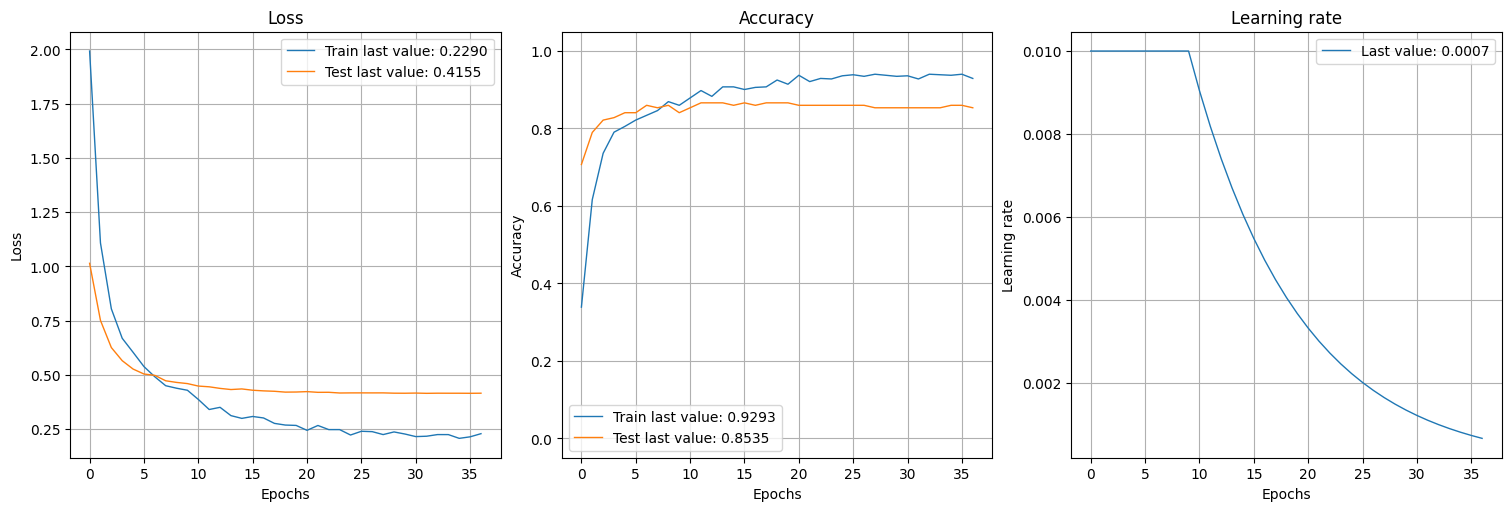

In [21]:
from tensorflow.keras.models import load_model


# Load the pre-trained model
best_model_resnet_sup = load_model('best_model_weights_class_sup_ResNet50_sgd_0.5.h5')

# Score de l'epoch optimal
#best_model_resnet_sup.load_weights('./best_model_weights_class_sup_ResNet50_sgd_0.5.h5')

loss_sup_dev_val, accuracy_sup_dev_val, = best_model_resnet_sup.evaluate(X_sup_dev_val, y_sup_dev_val, verbose=False)
print("Validation Accuracy for RESNET50 Model supervised classification:  {:.4f}".format(accuracy_sup_dev_val,))

loss_sup_test, accuracy_sup_test = best_model_resnet_sup.evaluate(X_sup_test, y_sup_test, verbose=False)
print("Test Accuracy for RESNET50 Model supervised classification:  {:.4f}".format(accuracy_sup_test))

Validation Accuracy for RESNET50 Model supervised classification:  0.8535
Test Accuracy for RESNET50 Model supervised classification:  0.7722


In [25]:
y_sup_dev_val_num = np.argmax(y_sup_dev_val, axis=1)
y_dev_test_pred = np.argmax(best_model_resnet_sup.predict(X_sup_dev_val), axis=1)

conf_mat = confusion_matrix(y_sup_dev_val_num, y_dev_test_pred)
print(conf_mat)

y_sup_dev_val_transform, corresp = conf_mat_transform2(y_sup_dev_val_num, y_dev_test_pred)
conf_mat_dev_test = confusion_matrix(y_dev_test_pred, y_sup_dev_val_transform)
print(conf_mat_dev_test)
print(classification_report(y_sup_dev_val_num, y_sup_dev_val_transform))

5/5 [==============================] - 11s 2s/step
[[18  1  0  1  2  0  0]
 [ 0 18  3  0  1  0  1]
 [ 1  0 21  0  0  1  0]
 [ 1  1  0 19  0  1  0]
 [ 3  0  0  2 18  0  0]
 [ 1  1  0  0  0 20  0]
 [ 0  0  0  1  0  1 20]]
<class 'numpy.ndarray'>
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[24  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0]
 [ 0  0 24  0  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  0  0 21  0  0]
 [ 0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0 21]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        22
           1       0.86      0.78      0.82        23
           2       0.88      0.91      0.89        23
           3       0.83      0.86      0.84        22
           4       0.86      0.78      0.82        23
           5       0.87      0.91      0.89        22
           6       0.95      0.91      0.93        22

    accuracy                           0.85       157
   macro avg       0.86      0.85      0.85       15

<AxesSubplot: >

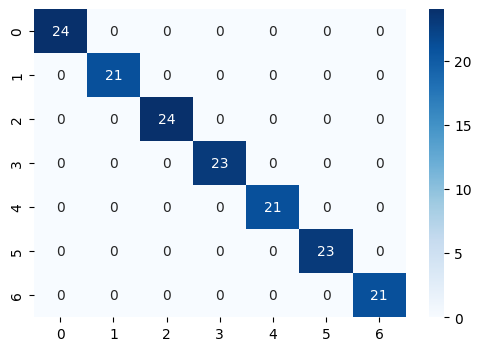

In [26]:
plt.figure(figsize = (6,4))
sns.heatmap(conf_mat_dev_test, annot=True, cmap="Blues")

In [27]:
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

In [ ]:
category_name = [key for key, value in sorted(category_dict.items(), key=lambda x: sorted_indices_list.index(x[1]))]

df_cm_transf = pd.DataFrame(conf_mat_dev_test, index=category_name, columns=corresp)